In [2]:
!pip install pandahouse

  Preparing metadata (setup.py) ... done
  Created wheel for pandahouse: filename=pandahouse-0.2.7-py2.py3-none-any.whl size=5904 sha256=946f77a3c6ca81f9c0d9952a2eb9f7f3961899928c8820222b54a983d73ff5d2
  Stored in directory: /root/.cache/pip/wheels/04/81/63/6896730711da10812121737bb505c6a8993800e99d39432522
Successfully built pandahouse


In [3]:
import pandas as pd

import pandahouse

import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px

# Задача
Мы наблюдаем внезапное падение активной аудитории! Нужно разобраться, какие пользователи не смогли воспользоваться лентой новостей, что их объединяет?

# Решение

In [4]:
# Подключение к БД
connection = {
    'host': 'https://clickhouse.lab.karpov.courses',
    'password': 'dpo_python_2020',
    'user': 'student',
    'database': 'simulator_20240320'
}
db='simulator_20240320'

In [5]:
q = f"""
  SELECT
    DATE(time) AS date,
    COUNT(DISTINCT user_id) DAU
  FROM {db}.feed_actions
  GROUP BY date
  ORDER BY date
"""

df = pandahouse.read_clickhouse(q, connection=connection)
df.head()

,date,DAU
0,2024-02-03,878
1,2024-02-04,2238
2,2024-02-05,3105
3,2024-02-06,3721
4,2024-02-07,4617


In [6]:
px.line(df, x='date', y='DAU')

In [15]:
q = f"""
  SELECT
    DATE(time) AS date,
    COUNT(DISTINCT user_id) DAU
  FROM {db}.feed_actions
  WHERE date = toDate('2024-03-23')
  GROUP BY date
"""

pandahouse.read_clickhouse(q, connection=connection)

,date,DAU
0,2024-03-23,14073


Провал пользователей произошёл 23.03.2024

In [18]:
target_date = "toDate('2024-03-23')"

## Возможные причины

Необходимо посчитать retention на следующий день

<Axes: xlabel='date', ylabel='retention'>

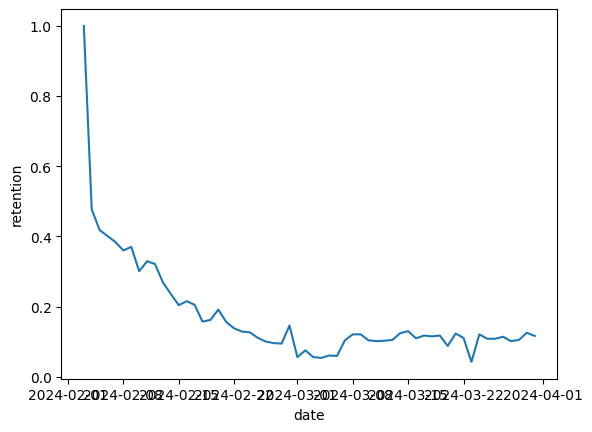

In [65]:
q = f"""
WITH t_segment_users AS (
  SELECT DISTINCT user_id
  FROM {db}.feed_actions
  WHERE DATE(time) = toDate('2024-02-3')
),
t_retention_1 AS (
  SELECT
  DATE(time) AS date,
    COUNT(DISTINCT user_id) AS uniq_users
  FROM {db}.feed_actions
  WHERE user_id IN t_segment_users
  GROUP BY date
),
t_retention_2 AS (
  SELECT
    date,
    uniq_users,
    MAX(uniq_users) OVER () AS uniq_users_day_0
  FROM t_retention_1
),
t_retention AS (
  SELECT
    date,
    uniq_users / uniq_users_day_0 AS retention
  FROM t_retention_2
)

SELECT *
FROM t_retention
"""

# pandahouse.read_clickhouse(q, connection=connection)
sns.lineplot(pandahouse.read_clickhouse(q, connection=connection), x='date', y='retention')

In [80]:
q = f"""
WITH t_segment_users AS (
  -- Сегменты пользователей
  SELECT
    -- DATE(time) AS date,
    groupUniqArray(user_id)
  FROM {db}.feed_actions
  -- GROUP BY date
)

SELECT *
FROM t_segment_users
"""

pandahouse.read_clickhouse(q, connection=connection)

KeyError: 'Array(UInt32)'

#### 1) ОС

In [24]:
q = f"""
  SELECT DISTINCT os
  FROM {db}.feed_actions
"""

pandahouse.read_clickhouse(q, connection=connection)

,os
0,Android
1,iOS


In [27]:
# Вчера
q = f"""
  SELECT
    -1 AS time_lag,
    countIf(DISTINCT user_id, os='Android') / countIf(DISTINCT user_id, os='iOS') AS uniq_users
  FROM {db}.feed_actions
  WHERE DATE(time) = {target_date} - 1
"""

pandahouse.read_clickhouse(q, connection=connection)

,time_lag,uniq_users
0,-1,1.852237


In [ ]:
q = f"""
  SELECT
    toDate('2024-03-14') AS target_date,
    countIf(DISTINCT user_id, source='ads') / COUNT(DISTINCT user_id) AS ads_users_part
  FROM {db}.feed_actions
  WHERE DATE(time)=target_date
"""

pandahouse.read_clickhouse(q, connection=connection)

,target_date,ads_users_part
0,2024-03-14,0.479773


На удивление в этот день рекламных пользователей было меньше, чем обычно

### Анализ отличия рекламных пользователей от органических в этот день

In [ ]:
q = f"""
  WITH
    t_target_users AS (
      SELECT DISTINCT user_id
      FROM {db}.feed_actions
      WHERE DATE(time)=toDate('2024-03-14')
    ),
    t_retention_1 AS (
      SELECT
        DATE(time) AS date,
        source,
        COUNT(DISTINCT user_id) AS uniq_users
      FROM {db}.feed_actions
      WHERE
        user_id IN t_target_users
        AND date >= toDate('2024-03-14')
      GROUP BY source, date
    ),
    t_retention_2 AS (
      SELECT
        date,
        source,
        uniq_users,
        MAX(uniq_users) OVER (
          PARTITION BY source
        ) AS uniq_users_0_day
      FROM t_retention_1
    ),
    t_retention AS (
      SELECT
        date,
        source,
        uniq_users / uniq_users_0_day AS retention
      FROM t_retention_2
    )

  SELECT *
  FROM t_retention
  ORDER BY source, date
"""

df = pandahouse.read_clickhouse(q, connection=connection)
df.head()

,date,source,retention
0,2024-03-14,ads,1.000000
1,2024-03-15,ads,0.162427
2,2024-03-16,ads,0.153589
3,2024-03-17,ads,0.147259
4,2024-03-18,ads,0.134241


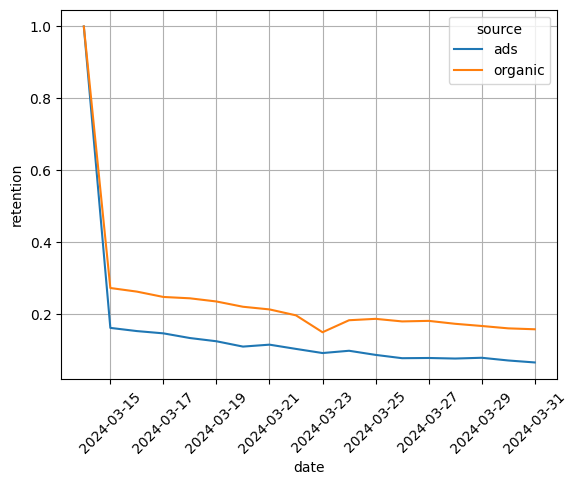

In [ ]:
plt.grid()
plt.xticks(rotation=45)
sns.lineplot(df, x='date', y='retention', hue='source');

**Вывод:**
- У органических пользователей retention стабильно больше
- Пользователи, пришедшие через рекламу, менее заинтересованы в продукте